## Following SMILE detection tutorial
detetcting smiles in a video stream

### Training the SMILE CNN

In [1]:
##will belong to train_model.py

In [3]:
#importing the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os
  

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
##first we have to set up the LeNet
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
class LeNet:
    
    def build(width, height, depth, classes):
        #inititalize the model
        model = Sequential()
        inputShape = (height, width, depth)
        
        #if we're using channels first then update the input shape
        if K.image_data_format()== "channels_first":
            inputShape = (depth, height, width)
            
        #first set of conv relu and pool layers
        model.add(Conv2D(20, (5,5), padding="same", input_shape = inputShape))
        #20 filters
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        #second set of conv relu and pool layers
        model.add(Conv2D(50, (5,5), padding="same"))
        #50 filters
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        #first set of FC and RELU
        model.add(Flatten())
        model.add(Dense(500)) #FC with 500 nodes
        model.add(Activation("relu"))
        #softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [5]:
##path to the SMILES dataset
dataset = "data/SMILEsmileD/"

In [6]:
data = []
labels = []

##loop over input images
for imagePath in sorted(paths.list_images(dataset)):
    #load image, preprocess and store
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width = 28) #resize to 28x28 for LeNet
    image = img_to_array(image)
    data.append(image)
    
    #get class labels and add to list
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)

In [7]:
#normalization 
data = np.array(data, dtype = "float") / 255.0
#one hot encoding
labels = np.array(labels)
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels),2)


In [8]:
# accounting for data imbalance by computing class weights
classTotals = labels.sum(axis = 0) #total number of examples per class
classWeights = classTotals.max() / classTotals
#every instance of "smiling" as 2.56 instances of "not smiling"

In [9]:
#split
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size = 0.21, stratify = labels, random_state = 42)

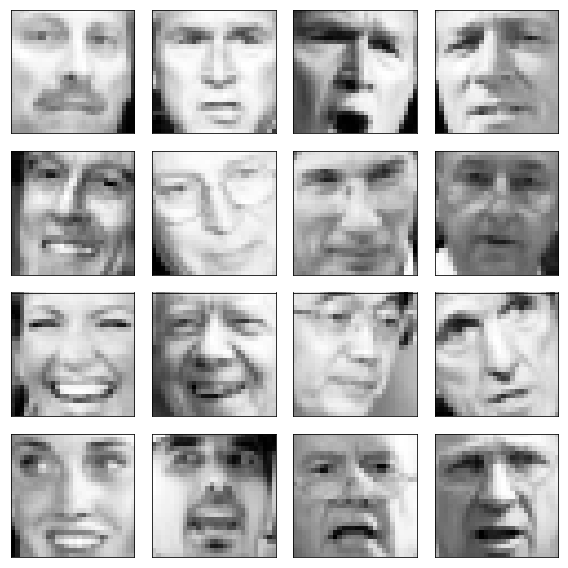

In [14]:
plotImages(trainX)

In [13]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(8,8))
    axes = axes.flatten()
    SIZE = 28
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("Title for first plot")
    plt.tight_layout()

In [15]:
#augmenting data
image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(trainX, augment=True)

In [18]:
augmented_images, _ = next( image_gen.flow( trainX, trainY, batch_size=4*4))

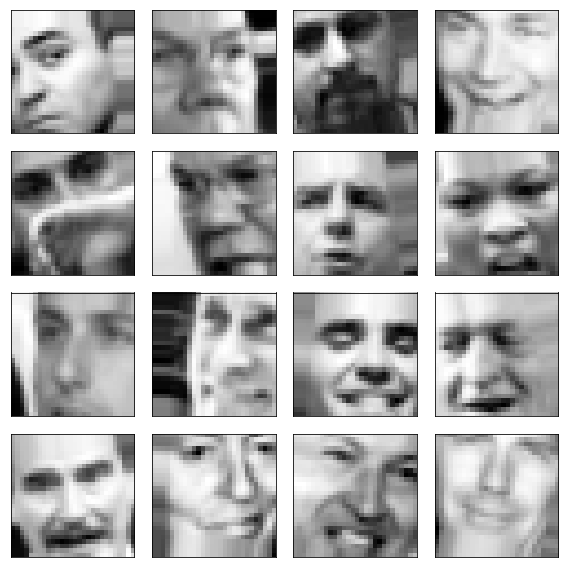

In [20]:
plotImages( augmented_images)

In [26]:
#train LeNet
model = LeNet.build(width = 28, height = 28, depth = 1, classes = 2)
model.compile(loss = "binary_crossentropy", 
              optimizer = "adam", metrics = ["accuracy"])
H = model.fit(trainX, trainY, validation_data = (testX, testY),
             class_weight = classWeights, batch_size = 64, 
              epochs = 20, verbose = 1)

Train on 10400 samples, validate on 2765 samples
Epoch 1/20
10400/10400 [==============================] - 14s 1ms/step - loss: 0.3912 - acc: 0.8243 - val_loss: 0.3007 - val_acc: 0.8738
Epoch 2/20
10400/10400 [==============================] - 14s 1ms/step - loss: 0.2752 - acc: 0.8871 - val_loss: 0.2757 - val_acc: 0.8897
Epoch 3/20
10400/10400 [==============================] - 14s 1ms/step - loss: 0.2506 - acc: 0.9023 - val_loss: 0.2753 - val_acc: 0.8929
Epoch 4/20
10400/10400 [==============================] - 14s 1ms/step - loss: 0.2342 - acc: 0.9092 - val_loss: 0.2657 - val_acc: 0.8944
Epoch 5/20
10400/10400 [==============================] - 15s 1ms/step - loss: 0.2187 - acc: 0.9163 - val_loss: 0.2635 - val_acc: 0.8969
Epoch 6/20
10400/10400 [==============================] - 15s 1ms/step - loss: 0.2079 - acc: 0.9195 - val_loss: 0.2472 - val_acc: 0.9052
Epoch 7/20
10400/10400 [==============================] - 14s 1ms/step - loss: 0.1956 - acc: 0.9277 - val_loss: 0.2438 - val_acc:

In [27]:
#evaluate the network
predictions = model.predict(testX, batch_size = 64)
print(classification_report(testY.argmax(axis = 1),
                           predictions.argmax(axis = 1), 
                            target_names = le.classes_))

             precision    recall  f1-score   support

not_smiling       0.90      0.96      0.93      1990
    smiling       0.88      0.73      0.80       775

avg / total       0.90      0.90      0.90      2765



In [28]:
#save the model
model.save("model/smiles_lenet_epochs20.hdf5")

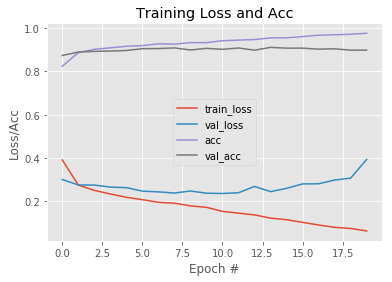

In [30]:
#plot the train test loss and acc
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,20), H.history["acc"], label="acc")
plt.plot(np.arange(0,20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Acc")
plt.legend()
plt.show()

In [42]:
#running the smile cnn in real time
#detect_smile.py
# import the necessary packages
from keras.preprocessing.image import img_to_array
#used to convert each individual frame from video stream to properly channel ordered array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2

In [54]:
cascade = "data/haarcascade_frontalface_default.xml"
#path to where the Haar face cascade resides
model_cnn = "model/smiles_lenet.hdf5"
#path to wear the model is saved
video = "data/test1.mp4"
#path to wear the video is

The Haar cascade algorithm is capable of detecting objects in images, regardless of their location and scale. the detector can run in real-time on modern hardware.
https://www.datacamp.com/community/tutorials/face-detection-python-opencv#face-detection
https://www.learnopencv.com/histogram-of-oriented-gradients/

In [53]:
#load the face detector cascade and smile detetctor CNN
detector = cv2.CascadeClassifier(cascade)
model1 = load_model(model_cnn)

In [55]:
#take web cam output else take video from path
if(video):
    camera = cv2.VideoCapture(video) #pre saved video file
else:
    camera = cv2.VideoCapture(0) #webcam

In [ ]:
#main processing pipeline
while True:
    #grab the current frame
    (grabbed, frame) = camera.read()
    
    #if we are viewing a video and didn't grab a frame, 
    #then we have reached the end of thr video
    if(video) and not grabbed:
        break 
        
    #resize the frame, convert to grayscale then clone the OG frame
    frame = imutils.resize(frame, width = 300)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameClone = frame.copy()
    
    #detect faces in the input frame
    rects = detector.detectMultiScale(gray, scaleFactor = 1.1,
                                      minNeighbors = 5, minSize = (30,30),
                                      flags = cv2.CASCADE_SCALE_IMAGE)
    #the face must have a min width of 30x30
    #minneighbors helps prune false positives
    #scalefactor controls the number of image pyramids generated
    #returns a list of 4-tuples that form a rectangle 
    #that bounds the face in the frame (x,y,h,w)
    for (fX, fY, fW, fH) in rects:
        #extract the ROI of face
        #resize to 28x28 and send to CNN
        roi = gray[fY:fY + fH, fX: fX + fW]
        roi = cv2.resize(roi, (28,28))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis = 0) #padding the image with an extra dimension
        
        #determine prob of smiling and not
        (notSmiling, smiling) = model1.predict(roi)[0]
        label = "Smiling" if smiling > notSmiling else "Not Smiling"
        
        #display the label and bounding box rectangle on subject
        cv2.putText(frameClone, label, (fX, fY - 10), 
                   cv2.FONT_HERSHEY_COMPLEX, 0.45, (0,0,255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0,0,255),2)
    
    cv2.imshow("Face", frameClone)
        
    #if 'q' key is pressed, stop the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

#cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()